In [42]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns




In [41]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [31]:
!pip install matplotlib

In [7]:


# Load data
df = pd.read_csv('data/raw/jobs_raw.csv.csv')

print(f"Original data: {len(df)} rows")


Original data: 2253 rows


In [5]:


# First look
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (2253, 16)

Column Names:
['Unnamed: 0', 'Job Title', 'Salary Estimate', 'Job Description', 'Rating', 'Company Name', 'Location', 'Headquarters', 'Size', 'Founded', 'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors', 'Easy Apply']

First 5 rows:
   Unnamed: 0                                          Job Title  \
0           0  Data Analyst, Center on Immigration and Justic...   
1           1                               Quality Data Analyst   
2           2  Senior Data Analyst, Insights & Analytics Team...   
3           3                                       Data Analyst   
4           4                             Reporting Data Analyst   

              Salary Estimate  \
0  $37K-$66K (Glassdoor est.)   
1  $37K-$66K (Glassdoor est.)   
2  $37K-$66K (Glassdoor est.)   
3  $37K-$66K (Glassdoor est.)   
4  $37K-$66K (Glassdoor est.)   

                                     Job Description  Rating  \
0  Are you eager to roll up your sleeves and harn.

In [8]:
# Drop unnecessary column
df = df.drop('Unnamed: 0', axis=1)


In [9]:
# ===== CLEAN SALARY =====
def clean_salary(salary_str):
    """Extract min and max salary from Glassdoor format"""
    if pd.isna(salary_str) or salary_str == '-1':
        return np.nan, np.nan
    
    # Remove $ and K, extract numbers
    # Format: "$37K-$66K (Glassdoor est.)"
    numbers = re.findall(r'\d+', str(salary_str))
    
    if len(numbers) >= 2:
        min_sal = float(numbers[0])
        max_sal = float(numbers[1])
        return min_sal, max_sal
    
    return np.nan, np.nan

In [10]:
# Apply salary cleaning
df[['min_salary_k', 'max_salary_k']] = df['Salary Estimate'].apply(
    lambda x: pd.Series(clean_salary(x))
)
df['avg_salary_k'] = (df['min_salary_k'] + df['max_salary_k']) / 2

print(f"\nSalary cleaned! {df['avg_salary_k'].notna().sum()} jobs have salary info")


Salary cleaned! 2252 jobs have salary info


In [12]:
# ===== CLEAN COMPANY NAME =====
# Remove ratings from company name (e.g., "Google\n4.5" -> "Google")
df['company_clean'] = df['Company Name'].str.split('\n').str[0]

In [13]:
# ===== CLEAN LOCATION =====
# Standardize city names
df['location_clean'] = df['Location'].str.strip()

# Extract state
df['state'] = df['location_clean'].str.split(',').str[-1].str.strip()

# Get just city
df['city'] = df['location_clean'].str.split(',').str[0].str.strip()

print(f"Location cleaned! Found {df['state'].nunique()} states")

Location cleaned! Found 19 states


In [14]:
# ===== EXTRACT SKILLS FROM JOB DESCRIPTION =====
print("\nExtracting skills from job descriptions...")


Extracting skills from job descriptions...


In [17]:
# Define skills to search for
skills_dict = {
    'python': ['python', 'py '],
    'r': [' r ', ' r,', ' r.', 'r programming'],
    'sql': ['sql', 'mysql', 'postgresql', 't-sql'],
    'excel': ['excel', 'spreadsheet'],
    'tableau': ['tableau'],
    'power_bi': ['power bi', 'powerbi', 'power-bi'],
    'sas': ['sas'],
    'spark': ['spark', 'pyspark'],
    'aws': ['aws', 'amazon web services'],
    'azure': ['azure', 'microsoft azure'],
    'machine_learning': ['machine learning', 'ml ', ' ml,'],
    'deep_learning': ['deep learning', 'neural network'],
    'statistics': ['statistics', 'statistical'],
    'hadoop': ['hadoop'],
    'java': ['java'],
    'scala': ['scala'],
    'git': ['git', 'github', 'version control'],
    'docker': ['docker'],
    'pandas': ['pandas'],
    'numpy': ['numpy'],
    'scikit': ['scikit', 'sklearn'],
    'tensorflow': ['tensorflow'],
    'pytorch': ['pytorch'],
    'nlp': ['nlp', 'natural language'],
    'data_visualization': ['data visualization', 'data viz'],
    'etl': ['etl', 'data pipeline']
}

# Convert job description to lowercase for searching
df['job_desc_lower'] = df['Job Description'].str.lower()

# Search for each skill
for skill, keywords in skills_dict.items():
    df[f'skill_{skill}'] = df['job_desc_lower'].apply(
        lambda x: 1 if any(keyword in str(x) for keyword in keywords) else 0
    )

# Drop the temporary lowercase column
df = df.drop('job_desc_lower', axis=1)

print("✓ Skills extracted!")

✓ Skills extracted!


In [18]:
# ===== CLEAN COMPANY SIZE =====
def parse_company_size(size_str):
    """Convert size ranges to numeric midpoint"""
    if pd.isna(size_str) or size_str == '-1' or 'Unknown' in str(size_str):
        return np.nan
    
    # Extract numbers
    numbers = re.findall(r'\d+', str(size_str))
    
    if len(numbers) >= 2:
        min_size = int(numbers[0])
        max_size = int(numbers[1])
        return (min_size + max_size) / 2
    elif '10000+' in str(size_str):
        return 15000
    
    return np.nan

df['company_size_numeric'] = df['Size'].apply(parse_company_size)

In [19]:
# ===== CREATE EXPERIENCE LEVEL (from job title) =====
def extract_seniority(title):
    """Extract seniority level from job title"""
    title_lower = str(title).lower()
    
    if any(word in title_lower for word in ['senior', 'sr.', 'lead', 'principal', 'staff']):
        return 'Senior'
    elif any(word in title_lower for word in ['junior', 'jr.', 'entry', 'associate']):
        return 'Junior'
    else:
        return 'Mid-Level'

df['seniority'] = df['Job Title'].apply(extract_seniority)

print(f"\nSeniority levels:")
print(df['seniority'].value_counts())


Seniority levels:
seniority
Mid-Level    1711
Senior        443
Junior         99
Name: count, dtype: int64


In [20]:
# ===== CLEAN RATING =====
# Replace -1 with NaN
df['rating_clean'] = df['Rating'].replace(-1, np.nan)


In [21]:
# ===== REMOVE DUPLICATES =====
print(f"\nBefore removing duplicates: {len(df)} rows")
df = df.drop_duplicates(subset=['Job Title', 'company_clean', 'Location'], keep='first')
print(f"After removing duplicates: {len(df)} rows")


Before removing duplicates: 2253 rows
After removing duplicates: 2242 rows


In [23]:
# ===== SELECT FINAL COLUMNS =====
final_columns = [
    'Job Title', 'company_clean', 'location_clean', 'city', 'state',
    'Salary Estimate', 'min_salary_k', 'max_salary_k', 'avg_salary_k',
    'rating_clean', 'seniority', 'Size', 'company_size_numeric',
    'Founded', 'Type of ownership', 'Industry', 'Sector', 'Revenue',
    'Job Description'
] + [col for col in df.columns if col.startswith('skill_')]

df_clean = df[final_columns].copy()

In [24]:
# Rename for clarity
df_clean = df_clean.rename(columns={
    'company_clean': 'company',
    'location_clean': 'location',
    'rating_clean': 'rating',
    'Size': 'company_size',
    'Type of ownership': 'ownership_type'
})

In [25]:
# ===== SAVE CLEANED DATA =====
df_clean.to_csv('data/processed/jobs_cleaned.csv', index=False)

print("\n" + "="*60)
print("DATA CLEANING COMPLETE! ✅")
print("="*60)
print(f"\nFinal dataset: {len(df_clean)} rows, {len(df_clean.columns)} columns")
print(f"\nSample of cleaned data:")
print(df_clean[['Job Title', 'company', 'city', 'state', 'avg_salary_k', 'seniority']].head(10))

print(f"\nMissing values in key columns:")
print(df_clean[['avg_salary_k', 'rating', 'company_size_numeric']].isnull().sum())

print(f"\nTop skills found:")
skill_cols = [col for col in df_clean.columns if col.startswith('skill_')]
skill_counts = {}
for col in skill_cols:
    skill_name = col.replace('skill_', '').replace('_', ' ').title()
    count = df_clean[col].sum()
    if count > 0:
        skill_counts[skill_name] = count


DATA CLEANING COMPLETE! ✅

Final dataset: 2242 rows, 45 columns

Sample of cleaned data:
                                           Job Title  \
0  Data Analyst, Center on Immigration and Justic...   
1                               Quality Data Analyst   
2  Senior Data Analyst, Insights & Analytics Team...   
3                                       Data Analyst   
4                             Reporting Data Analyst   
5                                       Data Analyst   
6                       Business/Data Analyst (FP&A)   
7                               Data Science Analyst   
8                                       Data Analyst   
9                      Data Analyst, Merchant Health   

                              company      city state  avg_salary_k  seniority  
0           Vera Institute of Justice  New York    NY          51.5  Mid-Level  
1  Visiting Nurse Service of New York  New York    NY          51.5  Mid-Level  
2                         Squarespace  New York   

In [27]:
# Sort and show top 10
top_skills = dict(sorted(skill_counts.items(), key=lambda x: x[1], reverse=True)[:10])
for skill, count in top_skills.items():
    percentage = (count / len(df_clean)) * 100
    print(f"  {skill:20s}: {count:4d} jobs ({percentage:.1f}%)")

print("\n✓ Cleaned data saved to: data/processed/jobs_cleaned.csv")
print("\nREADY FOR ANALYSIS! ")

  Sql                 : 1384 jobs (61.7%)
  Excel               : 1359 jobs (60.6%)
  Statistics          :  838 jobs (37.4%)
  Python              :  706 jobs (31.5%)
  Tableau             :  616 jobs (27.5%)
  Sas                 :  411 jobs (18.3%)
  Etl                 :  395 jobs (17.6%)
  R                   :  336 jobs (15.0%)
  Data Visualization  :  335 jobs (14.9%)
  Git                 :  303 jobs (13.5%)

✓ Cleaned data saved to: data/processed/jobs_cleaned.csv

READY FOR ANALYSIS! 


In [ ]:
# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [ ]:
# Load cleaned data
df = pd.read_csv('data/processed/jobs_cleaned.csv')

print(f"Analyzing {len(df)} jobs...\n")


Creating Visualization 1: Top Skills...


In [34]:
# ========== VISUALIZATION 1: TOP SKILLS ==========
print("Creating Visualization 1: Top Skills...")

skill_cols = [col for col in df.columns if col.startswith('skill_')]
skill_counts = {}
for col in skill_cols:
    skill_name = col.replace('skill_', '').replace('_', ' ').title()
    count = df[col].sum()
    if count > 0:
        skill_counts[skill_name] = count


Creating Visualization 1: Top Skills...


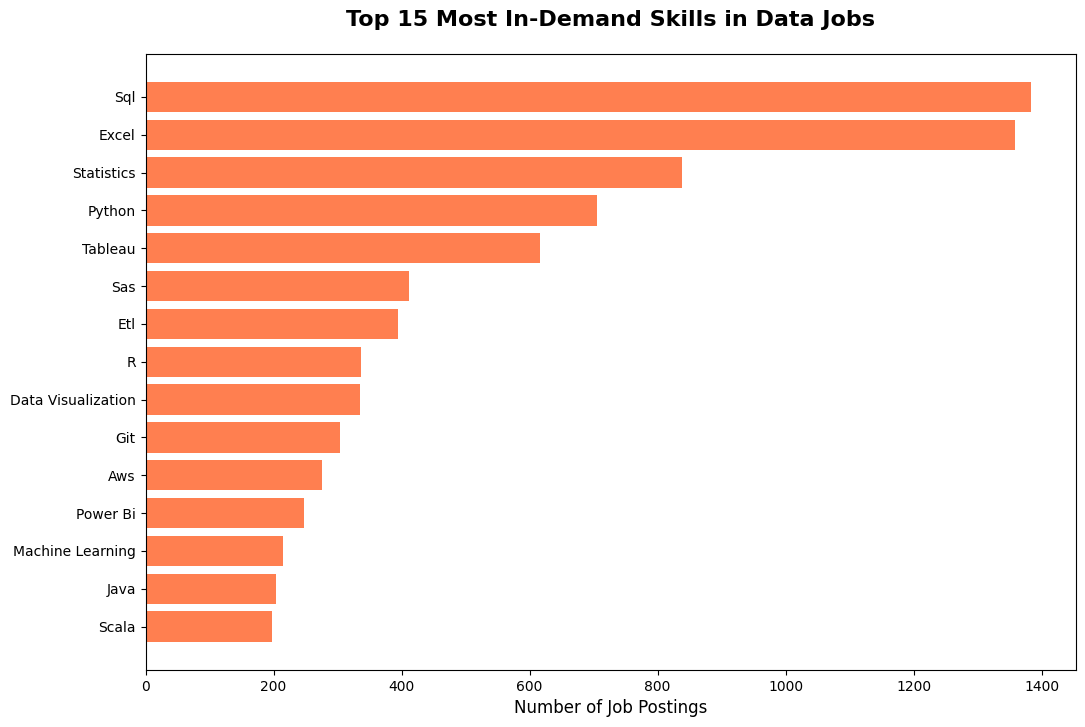

In [37]:
# Get top 15 skills
top_skills = dict(sorted(skill_counts.items(), key=lambda x: x[1], reverse=True)[:15])

fig, ax = plt.subplots(figsize=(12, 8))
skills = list(top_skills.keys())
counts = list(top_skills.values())
percentages = [(c/len(df))*100 for c in counts]

bars = ax.barh(skills, counts, color='coral')
ax.set_title('Top 15 Most In-Demand Skills in Data Jobs', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Number of Job Postings', fontsize=12)
ax.invert_yaxis()


In [38]:
# Add percentage labels
for i, (bar, count, pct) in enumerate(zip(bars, counts, percentages)):
    ax.text(count + 20, i, f'{count} ({pct:.1f}%)', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('outputs/plots/01_top_skills.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 01_top_skills.png")
plt.close()

✓ Saved: 01_top_skills.png


Creating Visualization 2: Salary Distribution...


C:\Users\user\AppData\Local\Temp\ipykernel_20704\819507184.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_with_salary, x='seniority', y='avg_salary_k', ax=axes[1], palette='Set2')


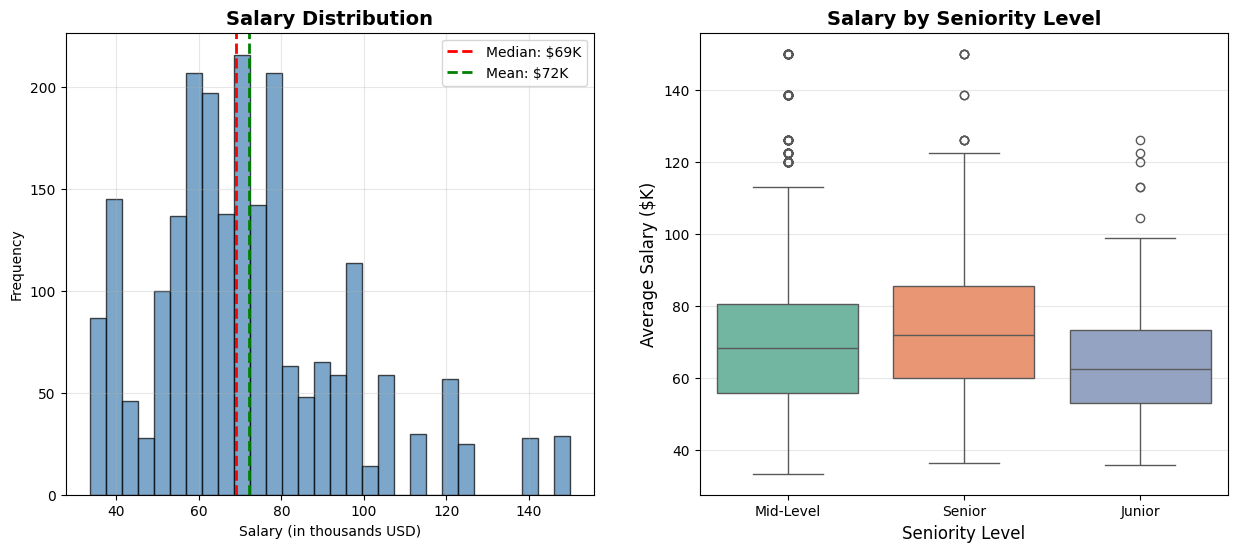

In [45]:
# ========== VISUALIZATION 2: SALARY DISTRIBUTION ==========
print("Creating Visualization 2: Salary Distribution...")

salary_data = df['avg_salary_k'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# Histogram
axes[0].hist(salary_data, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(salary_data.median(), color='red', linestyle='--', linewidth=2, 
                label=f'Median: ${salary_data.median():.0f}K')
axes[0].axvline(salary_data.mean(), color='green', linestyle='--', linewidth=2,
                label=f'Mean: ${salary_data.mean():.0f}K')
axes[0].set_title('Salary Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Salary (in thousands USD)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot by seniority
df_with_salary = df[df['avg_salary_k'].notna()]
sns.boxplot(data=df_with_salary, x='seniority', y='avg_salary_k', ax=axes[1], palette='Set2')
axes[1].set_title('Salary by Seniority Level', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Seniority Level', fontsize=12)
axes[1].set_ylabel('Average Salary ($K)', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

In [46]:
plt.tight_layout()
plt.savefig('outputs/plots/02_salary_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 02_salary_distribution.png")
plt.close()

✓ Saved: 02_salary_distribution.png


Creating Visualization 3: Geographic Distribution...


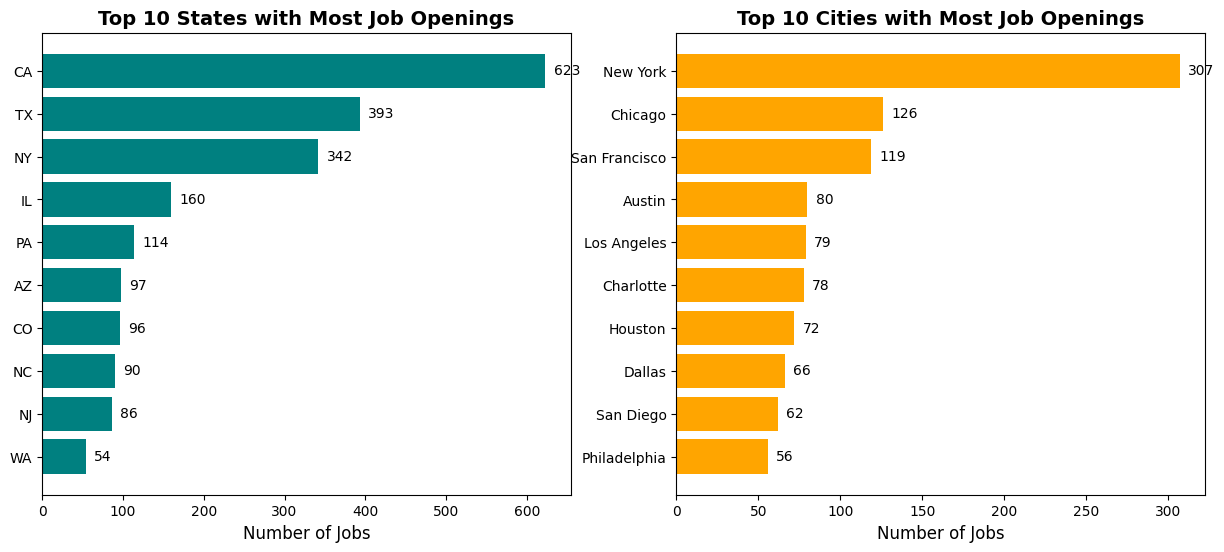

In [47]:
# ========== VISUALIZATION 3: TOP STATES/CITIES ==========
print("Creating Visualization 3: Geographic Distribution...")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Top states
top_states = df['state'].value_counts().head(10)
axes[0].barh(top_states.index, top_states.values, color='teal')
axes[0].set_title('Top 10 States with Most Job Openings', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Jobs', fontsize=12)
axes[0].invert_yaxis()
for i, v in enumerate(top_states.values):
    axes[0].text(v + 10, i, str(v), va='center')

# Top cities
top_cities = df['city'].value_counts().head(10)
axes[1].barh(top_cities.index, top_cities.values, color='orange')
axes[1].set_title('Top 10 Cities with Most Job Openings', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Jobs', fontsize=12)
axes[1].invert_yaxis()
for i, v in enumerate(top_cities.values):
    axes[1].text(v + 5, i, str(v), va='center')

In [48]:
plt.tight_layout()
plt.savefig('outputs/plots/03_geographic_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 03_geographic_distribution.png")
plt.close()

✓ Saved: 03_geographic_distribution.png


Creating Visualization 4: Salary by State...


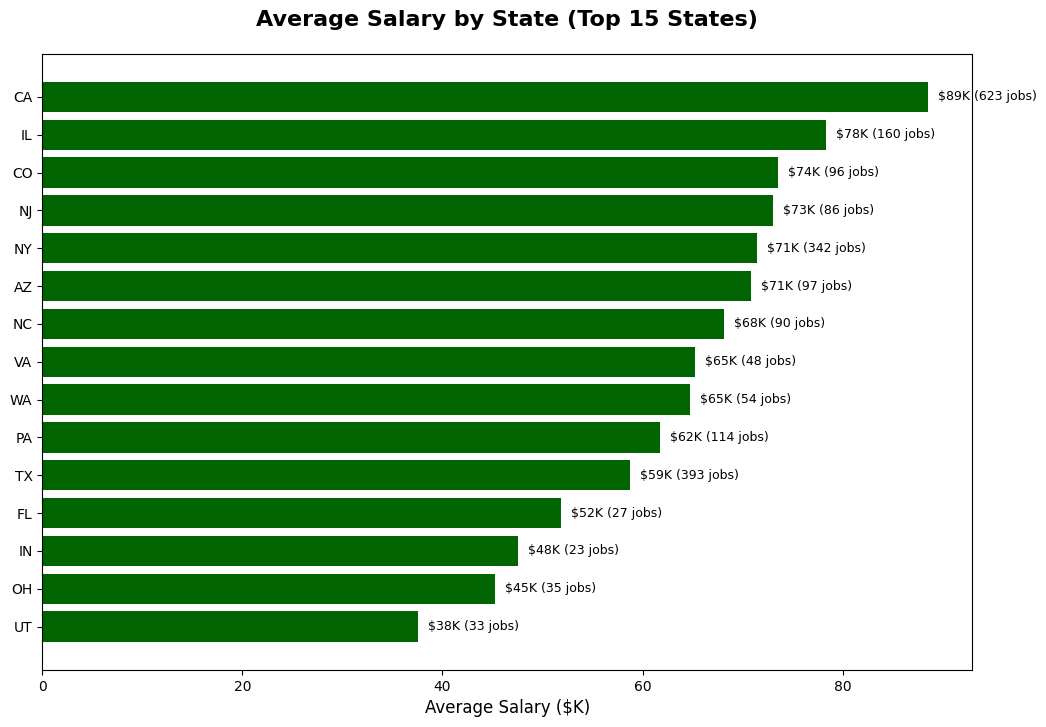

In [49]:
# ========== VISUALIZATION 4: SALARY BY STATE ==========
print("Creating Visualization 4: Salary by State...")

state_salary = df.groupby('state').agg({
    'avg_salary_k': 'mean',
    'Job Title': 'count'
}).rename(columns={'Job Title': 'job_count'})

# Filter states with at least 20 jobs
state_salary = state_salary[state_salary['job_count'] >= 20].sort_values('avg_salary_k', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(state_salary.index, state_salary['avg_salary_k'], color='darkgreen')
ax.set_title('Average Salary by State (Top 15 States)', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Average Salary ($K)', fontsize=12)
ax.invert_yaxis()

# Add labels
for i, (state, row) in enumerate(state_salary.iterrows()):
    ax.text(row['avg_salary_k'] + 1, i, f"${row['avg_salary_k']:.0f}K ({int(row['job_count'])} jobs)", 
            va='center', fontsize=9)

In [50]:
plt.tight_layout()
plt.savefig('outputs/plots/04_salary_by_state.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 04_salary_by_state.png")
plt.close()

✓ Saved: 04_salary_by_state.png


Creating Visualization 5: Top Hiring Companies...


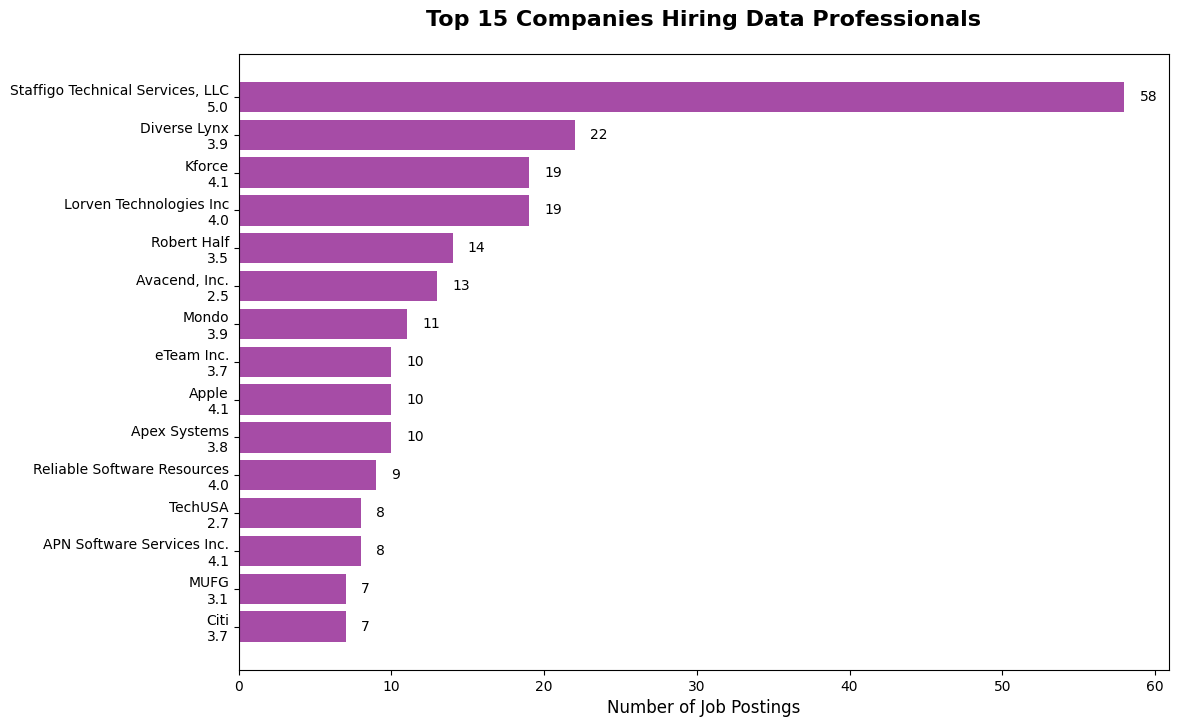

In [53]:
# ========== VISUALIZATION 5: TOP COMPANIES ==========
print("Creating Visualization 5: Top Hiring Companies...")

top_companies = df['Company Name'].value_counts().head(15)

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(top_companies.index, top_companies.values, color='purple', alpha=0.7)
ax.set_title('Top 15 Companies Hiring Data Professionals', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Number of Job Postings', fontsize=12)
ax.invert_yaxis()

for i, v in enumerate(top_companies.values):
    ax.text(v + 1, i, str(v), va='center', fontsize=10)


In [54]:
plt.tight_layout()
plt.savefig('outputs/plots/05_top_companies.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 05_top_companies.png")
plt.close()



✓ Saved: 05_top_companies.png


Creating Visualization 6: Skills by Seniority...


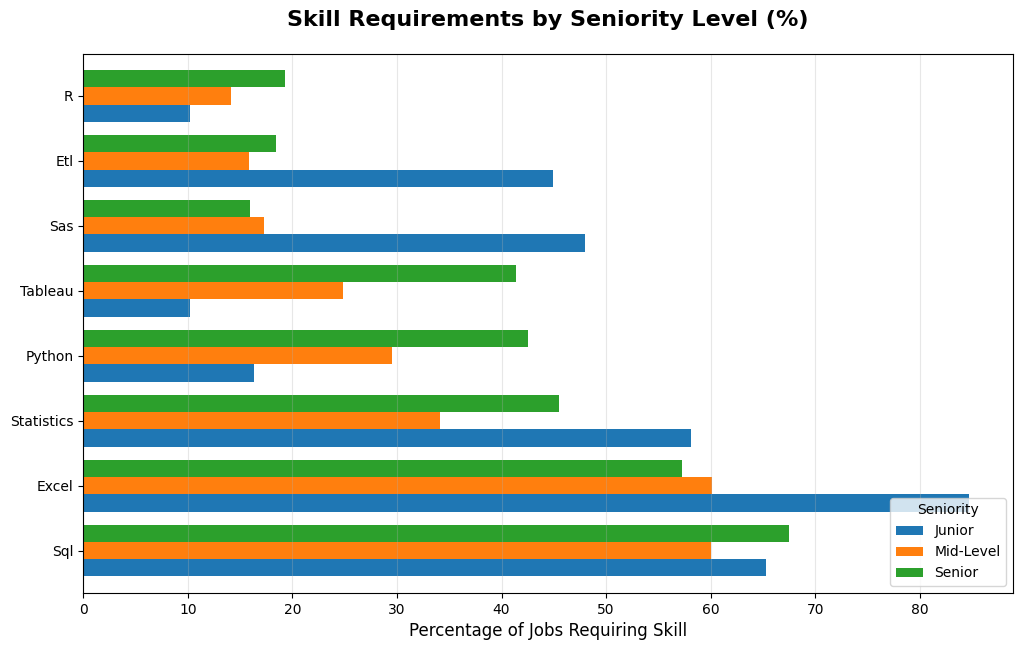

In [55]:
# ========== VISUALIZATION 6: SKILLS BY SENIORITY ==========
print("Creating Visualization 6: Skills by Seniority...")

# Top 8 skills
top_8_skills = list(dict(sorted(skill_counts.items(), key=lambda x: x[1], reverse=True)[:8]).keys())
top_8_cols = ['skill_' + s.lower().replace(' ', '_') for s in top_8_skills]

seniority_skills = df.groupby('seniority')[top_8_cols].mean() * 100

fig, ax = plt.subplots(figsize=(12, 7))
seniority_skills.T.plot(kind='barh', ax=ax, width=0.8)
ax.set_title('Skill Requirements by Seniority Level (%)', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Percentage of Jobs Requiring Skill', fontsize=12)
ax.set_yticklabels(top_8_skills)
ax.legend(title='Seniority', loc='lower right')
ax.grid(True, alpha=0.3, axis='x')

In [ ]:
# ========== VISUALIZATION 7: INDUSTRY DISTRIBUTION ==========
print("Creating Visualization 7: Industry Distribution...")

top_industries = df['Industry'].value_counts().head(12)

fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.tab20(range(len(top_industries)))
wedges, texts, autotexts = ax.pie(top_industries.values, labels=top_industries.index, autopct='%1.1f%%',
                                    startangle=90, colors=colors, textprops={'fontsize': 10})
ax.set_title('Job Distribution by Industry', fontsize=16, fontweight='bold', pad=20)

In [56]:
plt.tight_layout()
plt.savefig('outputs/plots/07_industry_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 07_industry_distribution.png")
plt.close()

✓ Saved: 07_industry_distribution.png


In [60]:
# ========== PRINT KEY INSIGHTS ==========
print("\n" + "="*70)
print("KEY INSIGHTS FROM ANALYSIS")
print("="*70)

print(f"\n📊 OVERALL STATISTICS:")
print(f"   Total Jobs Analyzed: {len(df)}")
print(f"   Unique Companies: {df['Company Name'].nunique()}")
print(f"   States Covered: {df['state'].nunique()}")
print(f"   Industries: {df['Industry'].nunique()}")

print(f"\n💰 SALARY INSIGHTS:")
median_sal = df['avg_salary_k'].median()
print(f"   Overall Median Salary: ${median_sal:.0f}K")
print(f"   Overall Mean Salary: ${df['avg_salary_k'].mean():.0f}K")
print(f"   Salary Range: ${df['avg_salary_k'].min():.0f}K - ${df['avg_salary_k'].max():.0f}K")

print(f"\n   By Seniority Level:")
for level in ['Junior', 'Mid-Level', 'Senior']:
    level_data = df[df['seniority'] == level]['avg_salary_k']
    if len(level_data) > 0:
        print(f"   {level:12s}: ${level_data.median():.0f}K median ({len(level_data)} jobs)")

print(f"\n🛠️  TOP 5 SKILLS:")
for i, (skill, count) in enumerate(list(top_skills.items())[:5], 1):
    pct = (count/len(df))*100
    print(f"   {i}. {skill:20s} - {count:4d} jobs ({pct:.1f}%)")

print(f"\n📍 TOP 5 STATES:")
for i, (state, count) in enumerate(top_states.head(5).items(), 1):
    pct = (count/len(df))*100
    avg_sal = df[df['state'] == state]['avg_salary_k'].median()
    print(f"   {i}. {state:15s} - {count:3d} jobs ({pct:.1f}%), ${avg_sal:.0f}K median")

print(f"\n🏢 TOP 5 HIRING COMPANIES:")
for i, (company, count) in enumerate(top_companies.head(5).items(), 1):
    print(f"   {i}. {company:40s} - {count:2d} openings")

print("\n" + "="*70)
print("✓ ALL VISUALIZATIONS CREATED SUCCESSFULLY!")
print("="*70)
print("\nNext: Create Streamlit Dashboard")


KEY INSIGHTS FROM ANALYSIS

📊 OVERALL STATISTICS:
   Total Jobs Analyzed: 2242
   Unique Companies: 1508
   States Covered: 19
   Industries: 89

💰 SALARY INSIGHTS:
   Overall Median Salary: $69K
   Overall Mean Salary: $72K
   Salary Range: $34K - $150K

   By Seniority Level:
   Junior      : $62K median (98 jobs)
   Mid-Level   : $68K median (1704 jobs)
   Senior      : $72K median (440 jobs)

🛠️  TOP 5 SKILLS:
   1. Sql                  - 1384 jobs (61.7%)
   2. Excel                - 1359 jobs (60.6%)
   3. Statistics           -  838 jobs (37.4%)
   4. Python               -  706 jobs (31.5%)
   5. Tableau              -  616 jobs (27.5%)

📍 TOP 5 STATES:
   1. CA              - 623 jobs (27.8%), $80K median
   2. TX              - 393 jobs (17.5%), $62K median
   3. NY              - 342 jobs (15.3%), $69K median
   4. IL              - 160 jobs (7.1%), $78K median
   5. PA              - 114 jobs (5.1%), $60K median

🏢 TOP 5 HIRING COMPANIES:
   1. Staffigo Technical Services,